In [38]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
from scripts.PreparaDataset import *
import matplotlib.pyplot as plt

In [ ]:
# Função para transformar a primeira letra em maiúscula
def primeira_letra_maiuscula(texto):
    return texto.title()

In [2]:
data = pd.read_csv('data/NFL.csv')

In [91]:
dataset = prepara_df(data)

dataset.loc[((dataset['Odds_H'] < dataset['Odds_A']) & (dataset['Back_Home'] == 1)), 'Back_Favorito'] = 1
dataset.loc[((dataset['Odds_H'] < dataset['Odds_A']) & (dataset['Back_Home'] == 0)), 'Back_Favorito'] = 0
dataset.loc[((dataset['Odds_H'] > dataset['Odds_A']) & (dataset['Back_Away'] == 1)), 'Back_Favorito'] = 1
dataset.loc[((dataset['Odds_H'] > dataset['Odds_A']) & (dataset['Back_Away'] == 0)), 'Back_Favorito'] = 0

dataset.loc[(dataset['Odds_H'] <= dataset['Odds_A']), 'odds'] = dataset['Odds_H']
dataset.loc[(dataset['Odds_H'] > dataset['Odds_A']), 'odds'] = dataset['Odds_A']

dataset = dataset[(dataset['odds'] > 1.55)]

dataset.dropna(inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [92]:
from pycaret.classification import *
cls = setup(data = dataset,
            target = 'Back_Favorito',
            train_size = 0.6,
            normalize = True,
            normalize_method = 'minmax',
            session_id = 2023,
            remove_outliers = True,
            verbose = False,
            )

x_treino = get_config('X_train')
y_treino = get_config('y_train')
x_teste = get_config('X_test')
y_teste = get_config('y_test')

treino = pd.concat([x_treino, y_treino], axis=1)
val = pd.concat([x_teste, y_teste],  axis=1)
print(f'Treino: {treino.shape[0]} | Validação: {val.shape[0]}')

Treino: 112 | Validação: 76


In [8]:
treino.to_excel('treino.xlsx')

<Axes: >

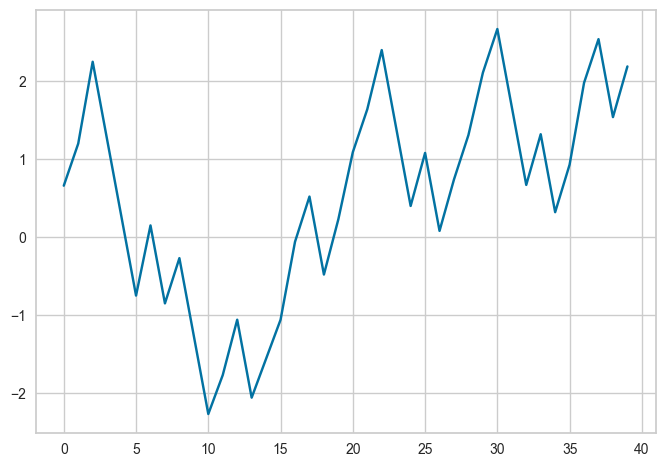

In [53]:
train = treino.copy()
train.loc[(train['Back_Home'] == 1), 'PL_H'] = train['Odds_H'] - 1
train.loc[(train['Back_Home'] == 0), 'PL_H'] = - 1
train.sort_values('Date', inplace=True)
train = train[(train['Odds_H'] >= 1.5) & (train['Odds_H'] < 2.1)]
train = train[(train['Avg_CG_H'] >= 10)]
train = train[(train['Last_CG_H'] >= 30)]
train = train[(train['CV_CG_H'] < 0.6)]
train.reset_index(drop=True, inplace=True)

train['acumulado'] = train['PL_H'].cumsum()
train.acumulado.plot()

<Axes: >

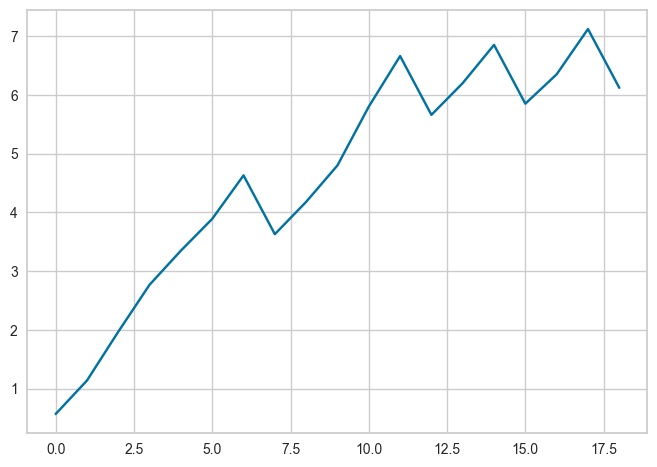

In [51]:
val.loc[(val['Back_Home'] == 1), 'PL_H'] = val['Odds_H'] - 1
val.loc[(val['Back_Home'] == 0), 'PL_H'] = - 1
val.sort_values('Date', inplace=True)

validation = val.copy()
validation = validation[(validation['Odds_H'] >= 1.5) & (validation['Odds_H'] < 2.1)]
validation = validation[(validation['Avg_CG_H'] >= 10)]
validation = validation[(validation['Last_CG_H'] >= 30)]
validation = validation[(validation['CV_CG_H'] < 0.6)]
validation.reset_index(drop=True, inplace=True)

validation['acumulado'] = validation['PL_H'].cumsum()
validation.acumulado.plot()

In [93]:
features = ['HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'Porc_Over_Home',
       'Porc_Over_Away', 'Avg_CG_H', 'DP_CG_H',
       'CV_CG_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A', 'Last_CG_H', 'Last_CG_A',
       'Acima_Last_CG_H', 'Acima_Last_CG_A', 'Abaixo_Last_CG_H',
       'Abaixo_Last_CG_A', 'CV_ML', 'CV_Over']

In [95]:
cls = setup(data = treino,
            ignore_features = [x for x in treino.columns.to_list() if x not in features and x != 'Back_Favorito'],
            target = 'Back_Favorito',
            train_size = 0.5,
            normalize = True,
            normalize_method = 'minmax',
            session_id = 2023,
            # feature_selection = True,
            # feature_selection_estimator = 'lr',
            # n_features_to_select = 6,
            remove_outliers = True,
            verbose = False
            )

In [96]:
model = compare_models(sort = 'precision', fold = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.6803,0.6722,0.8333,0.6652,0.7342,0.3406,0.3777,4.0900
gbc,Gradient Boosting Classifier,0.6242,0.6711,0.7000,0.6521,0.6685,0.2324,0.2357,4.1620
dt,Decision Tree Classifier,0.6227,0.6167,0.7000,0.6406,0.6629,0.2334,0.2367,4.2280
svm,SVM - Linear Kernel,0.6439,0.0000,0.8667,0.6345,0.7243,0.2578,0.2822,4.2300
ada,Ada Boost Classifier,0.5848,0.6422,0.6000,0.6117,0.5986,0.1684,0.1717,4.0880
et,Extra Trees Classifier,0.5682,0.6022,0.6333,0.5962,0.6106,0.1254,0.1249,4.3040
qda,Quadratic Discriminant Analysis,0.6076,0.5767,0.9667,0.5826,0.7257,0.1604,0.2111,4.1720
xgboost,Extreme Gradient Boosting,0.5530,0.6278,0.6667,0.5726,0.6136,0.0874,0.0895,4.1140
ridge,Ridge Classifier,0.5348,0.0000,0.6333,0.5676,0.5941,0.0512,0.0475,4.1240
catboost,CatBoost Classifier,0.5515,0.6456,0.6667,0.5621,0.6068,0.0883,0.0911,4.4140


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [97]:
model = create_model('lda', fold = 5, return_train_score = True)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [99]:
def info_modelo(modelo, data=None, filtro=''):
    if data is None:
        pred = predict_model(modelo, verbose = False)
        pred = pred.merge(dataset[['Date', 'odds']], left_index=True, right_index=True, how='left')
    else:
        pred = predict_model(modelo, data, verbose = False)
    
    stake = 1

    total = pred.shape[0]

    pred = pred[(pred['prediction_label'] == 1)]

    # Filtros
    if filtro != '':
        filtro_result = eval(filtro)
        pred = pred[filtro_result]

    pred.loc[(pred['Back_Favorito'] == 0), 'PL_BF_Predictions'] = - stake
    pred.loc[(pred['Back_Favorito'] == 1), 'PL_BF_Predictions'] = (pred['odds'] - 1) * stake
    
    plb = pred['PL_BF_Predictions'].sum()
    entradas = pred[pred['prediction_label'] == 1].shape[0]
    wr = round((pred[pred['Back_Favorito'] == 1].shape[0] / entradas), 2)
    oddback = pred['odds'].mean()
    med_gain = pred[pred['Back_Favorito'] == 1]['PL_BF_Predictions'].mean()
    med_loss = pred[pred['Back_Favorito'] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)
    print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
    print(f'Odd média: {oddback:.2f} ({1/oddback:.2f} WR)')
    print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
    print(f'EM: {ev:.2f}')
    print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')

    pred.sort_values(by='Date', inplace=True)
    pred.reset_index(drop=True, inplace=True)
    pred['hbacu'] = pred['PL_BF_Predictions'].cumsum()
    pred = pred[pred['prediction_label'] == 1]

    pred['hbacu'].plot.line(figsize=(9,2))
    plt.show()

    return pred

TESTE
PL: 0.72 | ROI: 2.88% | Prec.: 0.60
Odd média: 1.68 (0.59 WR)
Média Gain: 0.71 | Média Loss: -1.00
EM: 0.03
25 entradas em 56 jogos (44.64%)


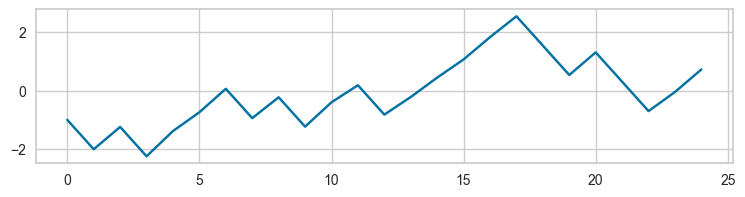

VALIDAÇÃO
PL: 0.13 | ROI: 0.33% | Prec.: 0.59
Odd média: 1.71 (0.58 WR)
Média Gain: 0.70 | Média Loss: -1.00
EM: 0.00
39 entradas em 76 jogos (51.32%)


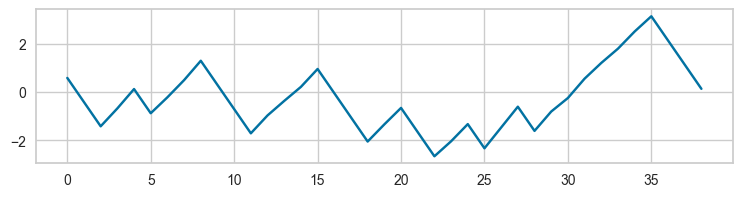

In [100]:
print('TESTE')
df = info_modelo(model)

print('VALIDAÇÃO')
final = finalize_model(model)
df_val = info_modelo(final, val)